# Probing exercise: Does Wav2Vec2 encode vocal tract movements?

---

Author: Charlotte Pouw

---

This notebook is part of the [Interspeech 2025](https://www.interspeech2025.org/home) tutorial on [_Interpretability Techniques for Speech Models_](https://interpretingdl.github.io/speech-interpretability-tutorial/).

This notebook shows an example of **probing**, which involves training a simple (often linear) model on the representations of a pre-trained neural model, to analyze which information is captured by those representations. In the speech domain, probing has been used to analyze the extent to which self-supervised speech models encode several levels of linguistic information, including phonology ([Pouw et al., 2024](https://direct.mit.edu/coli/article/50/4/1557/123790), [de Heer Kloots & Zuidema](https://www.isca-archive.org/interspeech_2024/deheerkloots24_interspeech.html)) and syntax ([Shen et al., 2023](https://www.isca-archive.org/interspeech_2023/shen23_interspeech.html)).

In this notebook, you will analyze the extent to which the Transformer layers of Wav2Vec2 encode **vocal tract movements**. The notebook is inspired by the following paper:

*C. J. Cho, P. Wu, A. Mohamed and G. K. Anumanchipalli, "**[Evidence of Vocal Tract Articulation in Self-Supervised Learning of Speech](https://ieeexplore.ieee.org/abstract/document/10094711)**," ICASSP 2023 - 2023 IEEE International Conference on Acoustics, Speech and Signal Processing (ICASSP), Rhodes Island, Greece, 2023, pp. 1-5, doi: 10.1109/ICASSP49357.2023.10094711.*

The image below is taken from the paper and shows the general framework:

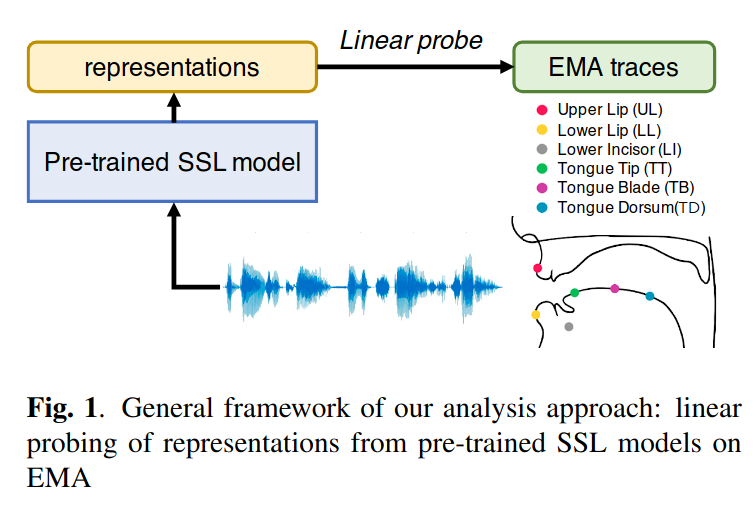

# **What is Electromagnetic Articulography (EMA)?**

**Electromagnetic Articulography (EMA)** measures real-time movements of several articulators (for example, the 6 articulators listed in Figure 1) during speech production. EMA uses sensor coils placed on the tongue and other parts of the mouth. It usually provides measurements across three dimensions:

X: posterior -> anterior

Y: right -> left

Z: inferior -> superior

Here's an illustration by Wielgat et al. (2017), excluding the Y dimension:

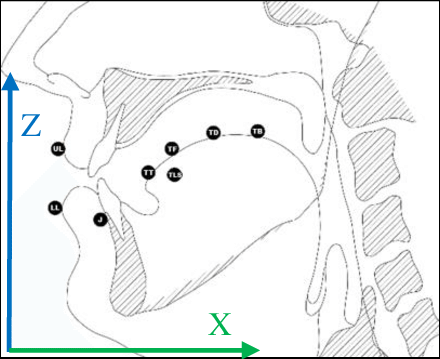

# **Why would an SSL model capture this?**

It has been shown that speech can be reconstructed from EMA features (see for example Wu et al., 2022). It could thus be useful for an SSL model to encode these features.

# **Let's start with the probing experiment!**

# Step 1. Load the data

**Dataset**

We will use a publicly available dataset by Tiede et al. (2017): https://yale.app.box.com/s/cfn8hj2puveo65fq54rp1ml2mk7moj3h/folder/30415804819

The dataset contains EMA features for 720 sentences per participant.These sentences are organized into:
- 12 blocks of 60 sentences each (B01 - B12)
- Two speaking rates: Normal (N) and Fast (F)
- Two repetitions per sentence (R01 and R02)

**Subset used in this notebook**

Here, we focus on the following subset of 60 sentences:

- Participant: F02
- Speaking Rate: Normal (N)
- Block: B01
- Repetition: R01

**Probing targets**

Following Cho et al. (2023), we select the 6 articulators listed in Figure 1, and only use the X and Y dimensions as probing targets.

To access the materials for this notebook:
1. Go to this [Google Drive folder](https://drive.google.com/drive/folders/1IYSwALkhkPtdMXmZL7dnTLYP_FMnFn9U?usp=sharing)
2. Click the folder name to open the dropdown menu, and select _Organize_ > _Add shortcut_ to add a shortcut to your own Google Drive account:
<br><img src="https://i.imgur.com/OuNj6NP.png" width="400">
3. Change the `TUTORIAL_PATH` variable in the cell below to point to the location of the shortcut in your Drive. Then mount your Google Drive into this Colab notebook by running the cell.

In [ ]:
# Mount drive
from google.colab import drive
drive.mount('/content/drive')

# Path to tutorial data
TUTORIAL_PATH = '/content/drive/MyDrive/InterspeechTutorial'

Mounted at /content/drive


We already preprocessed the data into two dataframes. The first dataframe contains the speech waveforms; the second dataframe contains the EMA features. Run the code below to load these dataframes.

In [ ]:
import pandas as pd
import numpy as np

# Load speech waveforms from participant F02
# we also provided data of participant MO2 --> change 'F02' to 'M02' to use that
audio_df_p1 = pd.read_pickle(f'{TUTORIAL_PATH}/ema_probing_data/ema_audio_F02.pkl')

# load EMA features for this participant
ema_features_p1 = pd.read_csv(f'{TUTORIAL_PATH}/ema_probing_data/ema_labels_F02.csv')

In [ ]:
# Select "Block 1" subset
# you can also select Block 2 --> "B02"
audio_df_p1 = audio_df_p1[audio_df_p1['FILENAME'].str.contains('B01')].reset_index()
ema_features_p1 = ema_features_p1[ema_features_p1['FILENAME'].str.contains('B01')].reset_index()

Each row in the audio dataframe corresponds to a single filename/sentence/waveform.

In [ ]:
# inspect the audio dataframe
audio_df_p1.head()

,index,FILENAME,SENTENCE,AUDIO
0,0,F02_B01_S26_R01_N.mat,Two blue fish swam in the tank.,"[0.009526947, 0.011340989, -0.0043769605, -0.0..."
1,2,F02_B01_S57_R01_N.mat,March the soldiers past the next hill.,"[-0.0041269585, -0.005239537, -0.0061851274, -..."
2,4,F02_B01_S49_R01_N.mat,The friendly gang left the drug store.,"[0.0011386061, 0.0006763126, -0.0034312992, -0..."
3,5,F02_B01_S31_R01_N.mat,Hoist the load to your left shoulder.,"[0.003375737, 0.008687873, 0.007837953, 0.0100..."
4,6,F02_B01_S30_R01_N.mat,Read verse out loud for pleasure.,"[0.0020485586, 0.0022934373, 0.0006079126, -9...."


The EMA dataframe has a slightly different structure: each row corresponds to a **single timestep**, and thus we have multiple rows per filename. The amount of rows depends on the duration of the sentence (the original sampling rate for the EMA features was 100 Hz, but we have downsampled them to 50 Hz so that we can align them with the Wav2Vec2 embeddings later).

Note that the columns of this dataframe correspond to the different articulators at different dimensions, e.g., 'TB_X' corresponds to the Tongue Blade at dimension X.

In [ ]:
# inspect the EMA features corresponding to an example filename
example_filename = 'F02_B01_S26_R01_N.mat'
ema_features_p1[ema_features_p1['FILENAME'] == example_filename].head()

,index,FILENAME,SENTENCE,TIMESTEP,TR_X,TR_Y,TB_X,TB_Y,TT_X,TT_Y,UL_X,UL_Y,LL_X,LL_Y,JAW_X,JAW_Y
0,0,F02_B01_S26_R01_N.mat,Two blue fish swam in the tank.,0,-52.407753,-5.276269,-37.269340,-9.158844,-19.764252,-3.638825,8.393078,-1.613125,6.871167,1.037663,-4.308311,-1.890733
1,1,F02_B01_S26_R01_N.mat,Two blue fish swam in the tank.,1,-52.374554,-5.075615,-37.228320,-9.103925,-19.934284,-3.727844,8.427053,-1.576766,6.995564,1.160876,-4.328567,-1.993190
2,2,F02_B01_S26_R01_N.mat,Two blue fish swam in the tank.,2,-52.425102,-4.947129,-37.352726,-9.014514,-20.362550,-3.826894,8.539426,-1.575178,7.130899,1.188108,-4.147757,-1.990244
3,3,F02_B01_S26_R01_N.mat,Two blue fish swam in the tank.,3,-52.433304,-4.794960,-37.551110,-8.894422,-20.626223,-4.019985,8.745736,-1.336377,7.330209,1.061128,-3.998986,-2.031662
4,4,F02_B01_S26_R01_N.mat,Two blue fish swam in the tank.,4,-52.312347,-4.661102,-37.673557,-8.724878,-20.962880,-4.094482,8.818155,-1.339843,7.460291,1.157283,-3.913648,-2.051805


To better understand what our data looks like, we plot the X and Y trajectories of the 6 articulators for an example sentence.

In [ ]:
# @title
import matplotlib.pyplot as plt
import pandas as pd

def plot_articulatory_trajectories(df, sentence_id=0):

    # Filter for a single sentence
    sentence = df['SENTENCE'].unique()[sentence_id]
    example_df = df[df['SENTENCE'] == sentence]

    # List of articulators
    articulators = ['TR', 'TB', 'TT', 'UL', 'LL', 'JAW']
    names = ['Tongue Rear', 'Tongue Blade', 'Tongue Tip', 'Upper Lip', 'Lower Lip', 'Lower Incisor (Jaw)']

    fig, axs = plt.subplots(2, 3, figsize=(18, 8), sharex=True)
    axs = axs.flatten()

    for i, (art, name) in enumerate(zip(articulators, names)):
        x_col = f'{art}_X'
        y_col = f'{art}_Y'

        axs[i].plot(example_df['TIMESTEP'], example_df[x_col], label='X', color='tab:blue', linewidth=3)
        axs[i].plot(example_df['TIMESTEP'], example_df[y_col], label='Y', color='tab:orange', linewidth=3)
        axs[i].set_title(f'{name}')
        axs[i].set_xlabel('Timestep (Hz)')
        axs[i].set_ylabel('Position (mm)')
        axs[i].grid(True)
        axs[i].legend(loc='best')

    plt.suptitle(f'X and Y trajectories for each articulator\nSentence: "{sentence}"', fontsize=14)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

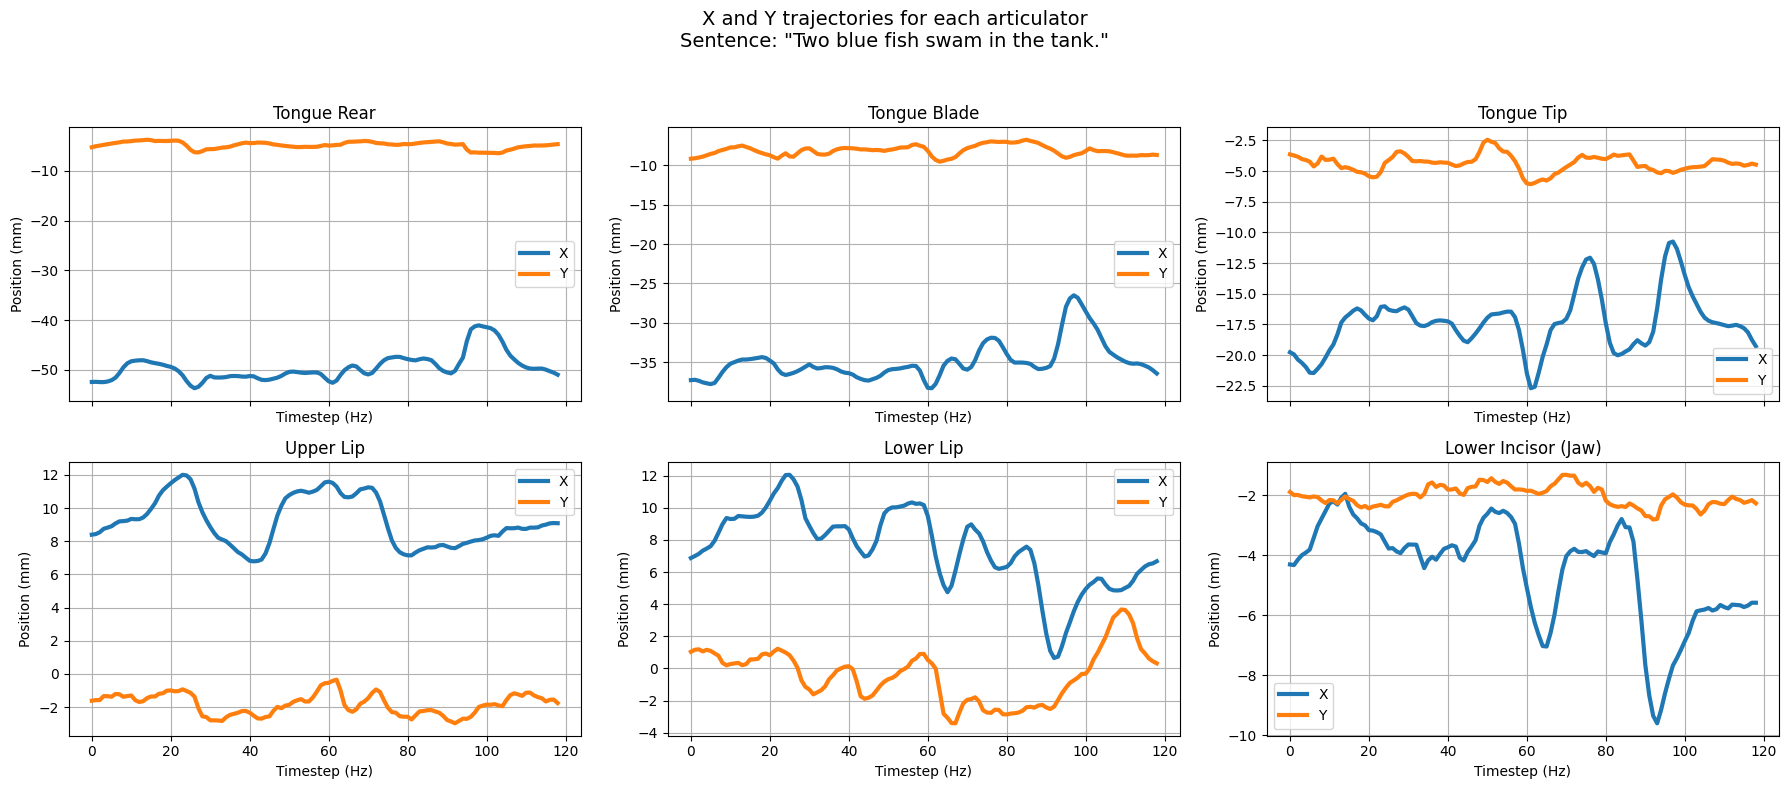

In [ ]:
plot_articulatory_trajectories(ema_features_p1, sentence_id=0)  # or change sentence_id to try a different one

# Step 2. Extracting embeddings from Wav2Vec2

We will now use the Wav2Vec2 model to extract contextualized representations from our speech waveforms (illustration from https://huggingface.co/blog/fine-tune-wav2vec2-english).

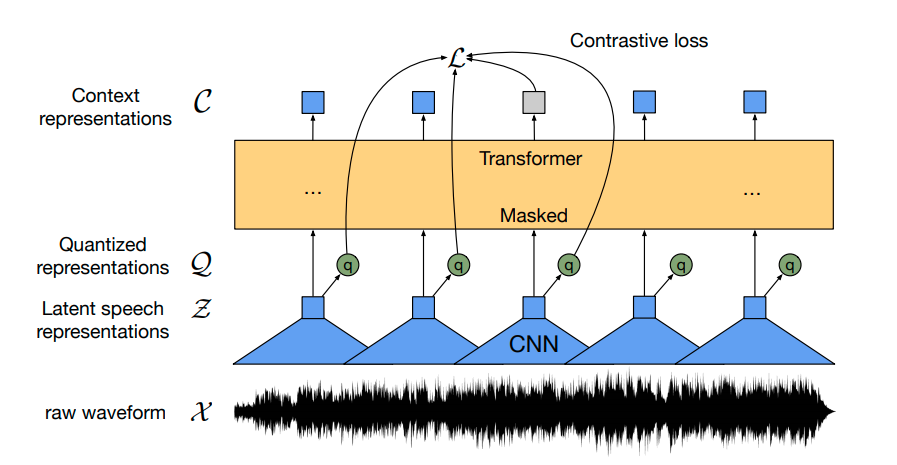

## Loading the model

In [ ]:
import torch
from transformers import Wav2Vec2Processor, Wav2Vec2Model
import numpy as np
import random
from scipy.signal import resample

def set_seed(seed):
    """Set random seed."""
    if seed == -1:
        seed = random.randint(0, 1000)
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)

    # if you are using GPU
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.enabled = False
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

# Set random seed
set_seed(42)

# Load model and processor
model = Wav2Vec2Model.from_pretrained("facebook/wav2vec2-base")
processor = Wav2Vec2Processor.from_pretrained("facebook/wav2vec2-base")

# Set model to evaluation mode
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
model.eval()
model.to(DEVICE)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json: 0.00B [00:00, ?B/s]

/usr/local/lib/python3.11/dist-packages/transformers/configuration_utils.py:334: UserWarning: Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 Transformers. Using `model.gradient_checkpointing_enable()` instead, or if you are using the `Trainer` API, pass `gradient_checkpointing=True` in your `TrainingArguments`.
  warnings.warn(


pytorch_model.bin:   0%|          | 0.00/380M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/380M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/159 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/163 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/291 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/85.0 [00:00<?, ?B/s]

Wav2Vec2Model(
  (feature_extractor): Wav2Vec2FeatureEncoder(
    (conv_layers): ModuleList(
      (0): Wav2Vec2GroupNormConvLayer(
        (conv): Conv1d(1, 512, kernel_size=(10,), stride=(5,), bias=False)
        (activation): GELUActivation()
        (layer_norm): GroupNorm(512, 512, eps=1e-05, affine=True)
      )
      (1-4): 4 x Wav2Vec2NoLayerNormConvLayer(
        (conv): Conv1d(512, 512, kernel_size=(3,), stride=(2,), bias=False)
        (activation): GELUActivation()
      )
      (5-6): 2 x Wav2Vec2NoLayerNormConvLayer(
        (conv): Conv1d(512, 512, kernel_size=(2,), stride=(2,), bias=False)
        (activation): GELUActivation()
      )
    )
  )
  (feature_projection): Wav2Vec2FeatureProjection(
    (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
    (projection): Linear(in_features=512, out_features=768, bias=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): Wav2Vec2Encoder(
    (pos_conv_embed): Wav2Vec2PositionalConvEmbedding(
  

## Extracting embeddings (for each timestep in each waveform)

The function below passes each speech waveform through Wav2Vec2. We then save the frame-level embeddings of each Transformer layer in a dictionary, formatted as follows:

```
{layer_idx: {filename}: [frame1, frame2, ..., frameN]}.
```

In [ ]:
import torch

def extract_hidden_states(model, processor, audio_df, num_layers):
    """
    Extract hidden states from Wav2Vec 2.0 transformer layers for each input waveform.

    Args:
        model: Pretrained Wav2Vec 2.0 model.
        processor: Corresponding Wav2Vec 2.0 processor.
        audio_df: Pandas DataFrame with columns 'FILENAME', 'SENTENCE', and 'AUDIO'.
        num_layers: Total number of transformer layers to extract.

    Returns:
        dict: Nested dictionary {layer_idx: {filename: [frame-level hidden states]}}.
    """
    model.eval()

    # Initialize dictionary to hold hidden states per layer and per file
    frame_states = {
        layer_idx: {}
        for layer_idx in range(num_layers)
    }

    for idx, (filename, waveform) in enumerate(zip(audio_df['FILENAME'], audio_df['AUDIO'])):
        print(f'Extracting hidden states from waveform {idx + 1}/{len(audio_df)}: {filename}')

        # Preprocess waveform
        inputs = processor(waveform, sampling_rate=16000, return_tensors="pt", padding=True)

        with torch.no_grad():
            outputs = model(**inputs, output_hidden_states=True, output_attentions=False)

        hidden_states = outputs.hidden_states  # Tuple of (layer, batch, time, features)

        # Save hidden states for each layer
        for layer_idx in range(num_layers):
            layer_output = hidden_states[layer_idx][0]  # Remove batch dim (batch size = 1)
            frame_states[layer_idx][filename] = [frame.cpu() for frame in layer_output]

    return frame_states

Run the cell below to extract embeddings from Wav2Vec2. We will use 50 sentences for training our probes, and the remaining 10 sentences for evaluation. [WARNING]: this may take some time, running this notebook on a GPU helps!

In [ ]:
import pickle

# Number of hidden layers of the transformer model + the input embeddings
num_layers = model.config.num_hidden_layers + 1

# Extract frame-level hidden states for training and testing the probes
frame_states_p1_train = extract_hidden_states(model, processor, audio_df_p1.head(50), num_layers) # first 50 sentences for training
frame_states_p1_test = extract_hidden_states(model, processor, audio_df_p1.tail(10), num_layers) # last 10 sentences for testing

In [ ]:
# # [OPTIONAL]: Save the extracted embeddings so we can load them again later.
# # Note that these files are quite big, so saving them saves time and may lead to RAM issues within the Colab environment.
# pickle.dump(frame_states_p1_train, open(f'{TUTORIAL_PATH}/ema_probing_data/frame_states_p1_train.pkl', 'wb'))
# pickle.dump(frame_states_p1_test, open(f'{TUTORIAL_PATH}/ema_probing_data/frame_states_p1_test.pkl', 'wb'))

# Step 3. Training & evaluating the probing models

Now that we have the embeddings, we can train our probes. We will train an individual model per 1) Wav2Vec2 layer, 2) articulator, and 3) dimension (X or Y). This results in 13 x 6 x 2 = 156 probes. We will evaluate each probe using Pearson's r, measuring the correlation between the true and predicted EMA features.

### Helper functions to for probe training & evaluation:

In [ ]:
# @title
import pickle
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from scipy.stats import pearsonr
import matplotlib.pyplot as plt

In [ ]:
# @title
# # [OPTIONAL] Load embeddings in case the extraction code above takes too long
# frame_states_p1_train = pickle.load(open(f'{TUTORIAL_PATH}/ema_probing_data/frame_states_p1_train.pkl', 'rb'))
# frame_states_p1_test = pickle.load(open(f'{TUTORIAL_PATH}/ema_probing_data/frame_states_p1_test.pkl', 'rb'))

In [ ]:
# @title
ARTICULATOR_NAMES = [
    'Tongue Rear X', 'Tongue Rear Y', 'Tongue Blade X', 'Tongue Blade Y',
    'Tongue Tip X', 'Tongue Tip Y', 'Upper Lip X', 'Upper Lip Y',
    'Lower Lip X', 'Lower Lip Y', 'Jaw X', 'Jaw Y'
]

In [ ]:
# @title
def prepare_data_for_layer(frame_states, ema_features, layer_idx):
    feature_vectors = []
    labels = []

    for filename in frame_states[layer_idx]:
        hidden_states = frame_states[layer_idx][filename]
        frame_labels = ema_features[ema_features['FILENAME'] == filename].copy()
        frame_labels.drop(columns=['index', 'FILENAME', 'SENTENCE', 'TIMESTEP'], inplace=True)

        # in case there is a slight mismatch between the number of hidden states and ema features
        min_len = min(len(hidden_states), len(frame_labels))
        targets_np = frame_labels.iloc[:min_len].to_numpy()

        for frame_idx in range(min_len):
            feature_vectors.append(hidden_states[frame_idx].numpy())
            labels.append(targets_np[frame_idx])

    feature_vectors = np.array(feature_vectors)
    labels_df = pd.DataFrame(labels, columns=ARTICULATOR_NAMES)

    return feature_vectors, labels_df

In [ ]:
# @title
def train_and_evaluate_probe_per_articulator(train_embeddings, test_embeddings, train_labels_df, test_labels_df):
    models = []
    r_values = []
    all_preds = pd.DataFrame(index=test_labels_df.index, columns=ARTICULATOR_NAMES)

    for articulator in ARTICULATOR_NAMES:
        model = LinearRegression()
        model.fit(train_embeddings, train_labels_df[articulator])

        predictions = model.predict(test_embeddings)
        all_preds[articulator] = predictions

        r, _ = pearsonr(test_labels_df[articulator], predictions)
        r_values.append(r)

        models.append(model)

    return r_values, models, all_preds

In [ ]:
# @title
def run_probes_all_layers(frame_states_train,
                          frame_states_test,
                          frame_labels,
                          num_layers):

    layer_scores = {}
    layer_preds = {}

    # Iterate over the layers
    for layer_idx in range(num_layers):

        print(f"Training probe on layer {layer_idx}...")

        # Prepare train and test data for this layer (get the frame embeddings + labels)
        train_embeddings, train_labels = prepare_data_for_layer(frame_states_train, frame_labels, layer_idx)
        test_embeddings, test_labels = prepare_data_for_layer(frame_states_test, frame_labels, layer_idx)

        # Train and evaluate a linear probe for each articulator at position X or Y
        r_values, models, predictions = train_and_evaluate_probe_per_articulator(train_embeddings, test_embeddings, train_labels, test_labels)

        # Save scores & predictions for this layer
        layer_scores[layer_idx] = r_values
        layer_preds[layer_idx] = predictions

    return layer_scores, layer_preds, test_labels

### Run the cell below to train & evaluate all probing models.

In [ ]:
# train and test on p1
layer_scores, layer_preds, test_labels = run_probes_all_layers(frame_states_p1_train,
                                                               frame_states_p1_test,
                                                               ema_features_p1,
                                                               num_layers)

Training probe on layer 0...
Training probe on layer 1...
Training probe on layer 2...
Training probe on layer 3...
Training probe on layer 4...
Training probe on layer 5...
Training probe on layer 6...
Training probe on layer 7...
Training probe on layer 8...
Training probe on layer 9...
Training probe on layer 10...
Training probe on layer 11...
Training probe on layer 12...


In [ ]:
# Print results
scores_df = pd.DataFrame(layer_scores).T  # shape: [num_layers x articulators]
scores_df.columns = ARTICULATOR_NAMES
scores_df.index.name = "Layer"
scores_df

,Tongue Rear X,Tongue Rear Y,Tongue Blade X,Tongue Blade Y,Tongue Tip X,Tongue Tip Y,Upper Lip X,Upper Lip Y,Lower Lip X,Lower Lip Y,Jaw X,Jaw Y
Layer,,,,,,,,,,,,
0,0.664030,0.351426,0.652305,0.399765,0.642075,0.430410,0.606231,0.466545,0.668783,0.421019,0.722241,0.225755
1,0.705569,0.313765,0.700659,0.472134,0.708699,0.473385,0.643236,0.498016,0.684813,0.448457,0.748155,0.223319
2,0.716335,0.335460,0.728422,0.473901,0.731727,0.456497,0.658913,0.490338,0.735874,0.473512,0.776624,0.267834
3,0.760644,0.250047,0.767116,0.445956,0.766408,0.471817,0.642286,0.472376,0.719633,0.452163,0.755987,0.272076
4,0.765067,0.347264,0.801435,0.431283,0.779569,0.494087,0.709431,0.537632,0.770302,0.465133,0.755651,0.212572
5,0.785838,0.332482,0.803404,0.425538,0.765475,0.494689,0.748693,0.481291,0.774075,0.438069,0.773718,0.252821
6,0.779347,0.360073,0.791864,0.400767,0.772642,0.462811,0.691786,0.526333,0.741596,0.401964,0.728524,0.222172
7,0.741908,0.297483,0.769564,0.337605,0.728867,0.398512,0.651991,0.472115,0.729864,0.449157,0.734226,0.251842
8,0.741876,0.317103,0.757331,0.283620,0.715336,0.336413,0.638366,0.438402,0.717140,0.371953,0.740427,0.178981


### Compute a baseline

When probing SSL models (or any neural models for that matter), it is important to compare the performance of these models against a baseline. This comparison helps us understand whether high performance arises because the probing task itself is easy, or because the SSL model actually captures the target information. Here we use Mel-Frequency Cepstral Coefficients (MFCCs) as a baseline.

In [ ]:
import torch
import torchaudio
import numpy as np

def extract_mfcc_as_baseline(audio_df, num_layers, sample_rate=16000, n_mfcc=13):
    """
    Compute MFCCs for each audio waveform and structure them like frame_states[layer][filename]
    so they can be used as a baseline in the probing pipeline.

    Args:
        audio_df: DataFrame with 'FILENAME' and 'AUDIO' columns.
        num_layers: Number of layers to simulate for compatibility with probing code.
        sample_rate: Sample rate of the audio (16kHz).
        n_mfcc: Number of MFCC coefficients per frame (default 13).

    Returns:
        dict: {layer_idx: {filename: [frame-level MFCC tensors]}} compatible with probing code.
    """
    # Initialize MFCC extractor
    mfcc_transform = torchaudio.transforms.MFCC(
        sample_rate=sample_rate,
        n_mfcc=n_mfcc,
        melkwargs={"n_fft": 400, "hop_length": 320}
    )

    # Here we will store the frame states, in the same format as we did for the Wav2Vec2 model
    mfcc_frame_states = {layer_idx: {} for layer_idx in range(num_layers)}

    # Iterate over the waveforms
    for idx, (filename, waveform) in enumerate(zip(audio_df['FILENAME'], audio_df['AUDIO'])):

        waveform = torch.tensor(waveform)
        waveform = waveform.unsqueeze(0)  # shape: (1, time)

        # Compute MFCC: (1, n_mfcc, time) → squeeze and transpose to (time, n_mfcc)
        mfcc = mfcc_transform(waveform).squeeze(0).transpose(0, 1)

        # Put MFCC frames in a list
        frame_list = [frame.cpu() for frame in mfcc]

        # Fill in all layers with the same MFCCs
        for layer_idx in range(num_layers):
            mfcc_frame_states[layer_idx][filename] = frame_list

    return mfcc_frame_states

In [ ]:
# Compute baseline MFCC features for train and test set
mfcc_states_p1_train = extract_mfcc_as_baseline(audio_df_p1.head(50), num_layers)
mfcc_states_p1_test = extract_mfcc_as_baseline(audio_df_p1.tail(10), num_layers)

# Run the probing pipeline using MFCCs as input features
mfcc_scores, mfcc_preds, mfcc_test_labels = run_probes_all_layers(
    mfcc_states_p1_train,
    mfcc_states_p1_test,
    ema_features_p1,
    num_layers
)

/usr/local/lib/python3.11/dist-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(


Training probe on layer 0...
Training probe on layer 1...
Training probe on layer 2...
Training probe on layer 3...
Training probe on layer 4...
Training probe on layer 5...
Training probe on layer 6...
Training probe on layer 7...
Training probe on layer 8...
Training probe on layer 9...
Training probe on layer 10...
Training probe on layer 11...
Training probe on layer 12...


In [ ]:
# Print results
scores_df = pd.DataFrame(mfcc_scores).T  # shape: [num_layers x articulators]
scores_df.columns = ARTICULATOR_NAMES
scores_df.index.name = "Layer"
scores_df

,Tongue Rear X,Tongue Rear Y,Tongue Blade X,Tongue Blade Y,Tongue Tip X,Tongue Tip Y,Upper Lip X,Upper Lip Y,Lower Lip X,Lower Lip Y,Jaw X,Jaw Y
Layer,,,,,,,,,,,,
0,0.596208,0.219565,0.57578,0.291123,0.538873,0.338155,0.42947,0.328356,0.506489,0.249441,0.622657,0.139148
1,0.596208,0.219565,0.57578,0.291123,0.538873,0.338155,0.42947,0.328356,0.506489,0.249441,0.622657,0.139148
2,0.596208,0.219565,0.57578,0.291123,0.538873,0.338155,0.42947,0.328356,0.506489,0.249441,0.622657,0.139148
3,0.596208,0.219565,0.57578,0.291123,0.538873,0.338155,0.42947,0.328356,0.506489,0.249441,0.622657,0.139148
4,0.596208,0.219565,0.57578,0.291123,0.538873,0.338155,0.42947,0.328356,0.506489,0.249441,0.622657,0.139148
5,0.596208,0.219565,0.57578,0.291123,0.538873,0.338155,0.42947,0.328356,0.506489,0.249441,0.622657,0.139148
6,0.596208,0.219565,0.57578,0.291123,0.538873,0.338155,0.42947,0.328356,0.506489,0.249441,0.622657,0.139148
7,0.596208,0.219565,0.57578,0.291123,0.538873,0.338155,0.42947,0.328356,0.506489,0.249441,0.622657,0.139148
8,0.596208,0.219565,0.57578,0.291123,0.538873,0.338155,0.42947,0.328356,0.506489,0.249441,0.622657,0.139148


# Step 4. Analyze probing performance

Below we plot the probing performance across layers. Both types of input representations (Wav2Vec2 and MFCC) perform above chance. Wav2Vec2 generally outperforms MFCC, but we also see that the X dimension is easier to predict than the Y dimension (the baseline MFCC performance is higher for X).

In [ ]:
# @title
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

def plot_scores(layer_scores_wav2vec, layer_scores_baseline):
    """
    Plot probe scores across Wav2Vec2 layers and compare to MFCC baseline.
    """
    layers = sorted(layer_scores_wav2vec.keys())
    num_labels = 12
    labels = ['Tongue Rear X', 'Tongue Rear Y', 'Tongue Blade X', 'Tongue Blade Y',
              'Tongue Tip X', 'Tongue Tip Y', 'Upper Lip X', 'Upper Lip Y',
              'Lower Lip X', 'Lower Lip Y', 'Jaw X', 'Jaw Y']

    # Retrieve Wav2Vec2 scores
    scores_by_label_wav2vec = [[] for _ in range(num_labels)]
    for layer in layers:
        for i in range(num_labels):
            scores_by_label_wav2vec[i].append(layer_scores_wav2vec[layer][i])

    # Retrieve MFCC scores
    scores_by_label_baseline = [[] for _ in range(num_labels)]
    for layer in layers:
        for i in range(num_labels):
            scores_by_label_baseline[i].append(layer_scores_baseline[layer][i])

    # Split X and Y
    x_labels = labels[::2]
    y_labels = labels[1::2]
    x_scores_wav2vec = scores_by_label_wav2vec[::2]
    y_scores_wav2vec = scores_by_label_wav2vec[1::2]
    x_scores_baseline = scores_by_label_baseline[::2]
    y_scores_baseline = scores_by_label_baseline[1::2]

    fig, axs = plt.subplots(1, 2, figsize=(16, 6), sharey=True)
    cmap = plt.get_cmap('tab10', 6)

    # Plot X-dimension
    for i in range(6):
        color = cmap(i)
        axs[0].plot(layers, x_scores_wav2vec[i], marker='o', linestyle='-', color=color)
        axs[0].plot(layers, x_scores_baseline[i], linestyle='--', color=color)
    axs[0].axhline(0, color='gray', linestyle='-', linewidth=2, label='Chance Performance') # chance performance: zero correlation
    axs[0].set_title('X dimension (front-back)')
    axs[0].set_xlabel('Layer Index')
    axs[0].set_ylabel('Score (Pearson r)')
    axs[0].grid(True)
    axs[0].set_xticks(layers)
    axs[0].set_ylim(-0.4, 1)

    # Plot Y-dimension
    for i in range(6):
        color = cmap(i)
        axs[1].plot(layers, y_scores_wav2vec[i], marker='o', linestyle='-', color=color)
        axs[1].plot(layers, y_scores_baseline[i], linestyle='--', color=color)
    axs[1].axhline(0, color='gray', linestyle='-', linewidth=2, label='Chance Performance') # chance performance: zero correlation
    axs[1].set_title('Y dimension (right-left)')
    axs[1].set_xlabel('Layer Index')
    axs[1].grid(True)
    axs[1].set_xticks(layers)

    # Create custom legend handles
    articulator_lines = [Line2D([0], [0], color=cmap(i), lw=2) for i in range(6)]
    articulator_labels = [x_label.replace('X', '') for x_label in x_labels]

    model_lines = [
        Line2D([0], [0], color='black', linestyle='-', lw=2),
        Line2D([0], [0], color='black', linestyle='--', lw=2),
        Line2D([0], [0], color='gray', linestyle='-', lw=2)
    ]
    model_labels = ['Wav2Vec2', 'MFCC Baseline', 'Chance Performance']

    # Combine both lists
    combined_lines = articulator_lines + model_lines
    combined_labels = articulator_labels + model_labels

    # Add combined legend
    axs[0].legend(combined_lines, combined_labels, title='Articulator & Model', loc='lower right', fontsize=9)

    # Title and layout
    plt.suptitle('Wav2Vec2 vs MFCC Baseline - Probe performance per articulator', fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

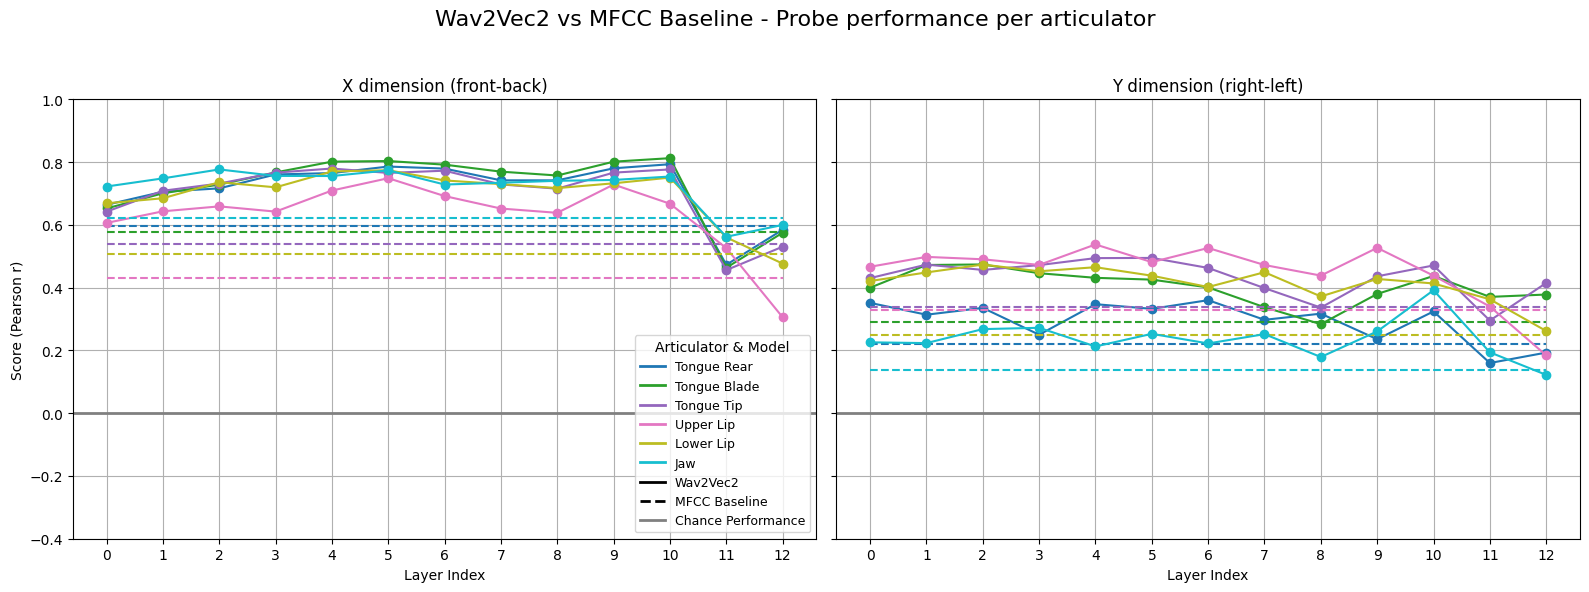

In [ ]:
plot_scores(layer_scores, mfcc_scores)

We see that probing performance is generally better for the X dimension (front-back) compared to the Y dimension (left-right). Why could this be? To better understand this, we can take a look at the true and predicted values for a layer, articulator and dimension of choice.

Note that we also pass a y-axis range to the function. This ensures that the relative magnitude of articulator movements is visually comparable. The absolute values of the y-min and y-max differ depend on the articulator, but we keep the range (i.e., the difference between min and max) fixed. We use a range of 20 millimeters in the plots below.

In [ ]:
# @title
def plot_true_and_predicted_values(articulator_name, dimension, model_layer, y_axis_range=None, n_timesteps=300):
    column = f'{articulator_name} {dimension}'

    # Retrieve true and predicted values
    true = test_labels[column].iloc[:n_timesteps]
    pred_wav2vec = layer_preds[model_layer][column].iloc[:n_timesteps]
    pred_mfcc = mfcc_preds[model_layer][column].iloc[:n_timesteps]

    # Plot
    plt.figure(figsize=(14, 4))
    plt.plot(true, label="True", color='black', linewidth=1.5)
    plt.plot(pred_wav2vec, label="Wav2Vec2", color='tab:blue', alpha=0.8)
    plt.plot(pred_mfcc, label="MFCC Baseline", color='tab:orange', alpha=0.8)

    plt.title(f"Layer {model_layer} - {column} - Prediction vs. Ground Truth", fontsize=14)
    plt.xlabel("Timestep (Hz)", fontsize=12)
    plt.ylabel("Position (mm)", fontsize=12)
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    if y_axis_range:
      plt.ylim(y_axis_range)
    plt.show()

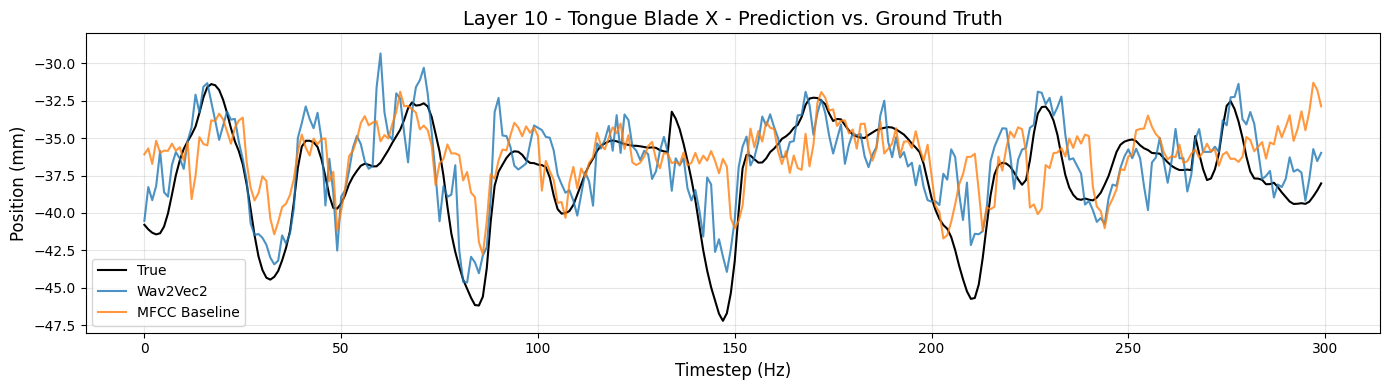

In [ ]:
# Tongue Blade X (front-back)
articulator_name = 'Tongue Blade'
dimension = 'X'
model_layer = 10

plot_true_and_predicted_values(articulator_name, dimension, model_layer, y_axis_range=(-48,-28), n_timesteps=300)

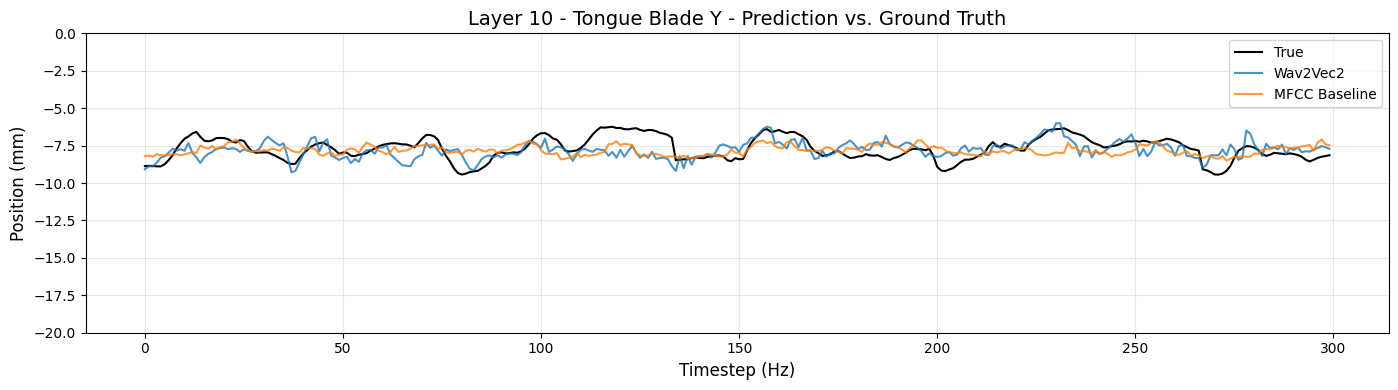

In [ ]:
# Tongue Blade Y (right-left)
articulator_name = 'Tongue Blade'
dimension = 'Y'
model_layer = 10

plot_true_and_predicted_values(articulator_name, dimension, model_layer, y_axis_range=(-20,0), n_timesteps=300)

# Discussion

The original study by Cho et al. (2023) reported correlation scores across a range of different SSL models (see Figure 2 below). We see that the SSL models generally outperform the acoustic baselines (fbank, mfcc, mel), although some variation can be observed depending on which speaker's data is used in the experiments.

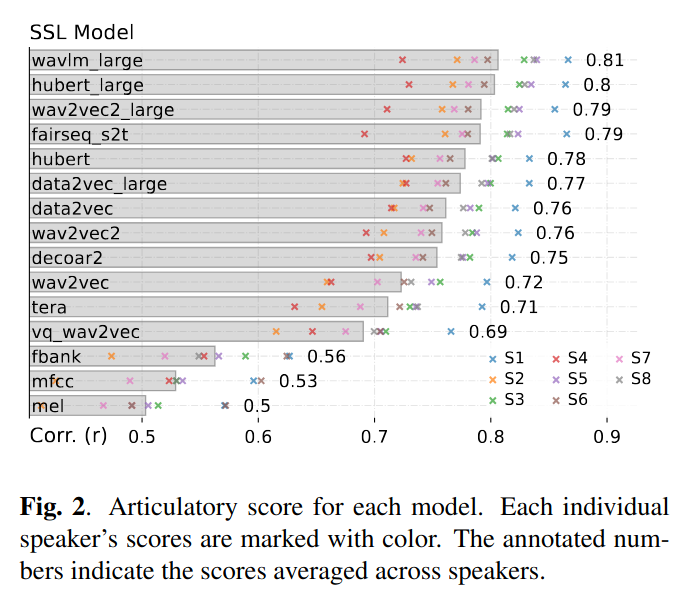


# Outlook

Our probing results have given us a global picture of how EMA features are encoded by Wav2Vec2, but can we gain deeper insights about this? Generally, **probing results can be used as a first scan**, allowing us to generate novel hypotheses about the model, and to design follow-up experiments targeting more fine-grained questions.

**Some ideas for follow-up questions**:

- Are there differences in the decodability of EMA features across different phones?
- How robust are the probing results across participants? What happens if we train the probes on participant A and test them on participant B?